In [2]:
import librosa as lr
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

"""https://keras.io/examples/audio/melgan_spectrogram_inversion/"""

### Speaker Recognition

This Notebook aims to implement speaker recognition using two different approaches, Convolution Neural Networks combined with Mel Spectrograms and Linear Vector Quantization.

AttributeError: module 'matplotlib' has no attribute 'axes'

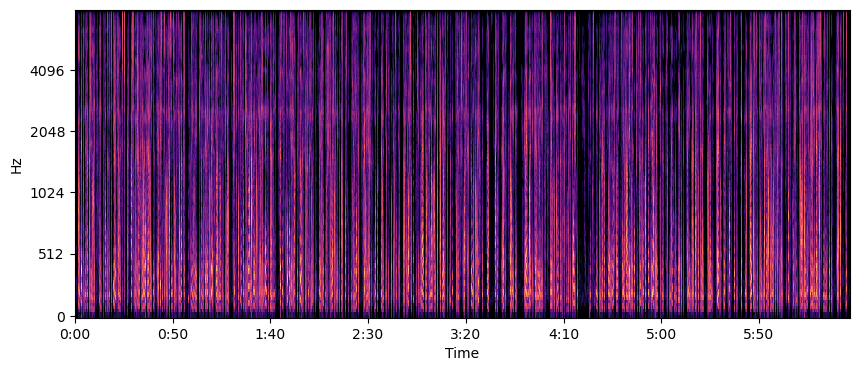

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
audio_data_dir = os.path.join(os.getcwd(), "Data", "audio")

y, sr = lr.load(f"{audio_data_dir}/schwarzenberger.wav")
lr.feature.melspectrogram(y=y, sr=sr)

%matplotlib inline
D = np.abs(lr.stft(y))**2
S = lr.feature.melspectrogram(S=D)
S = lr.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
lr.display.specshow(lr.power_to_db(S,ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

### Dataset Preparation

In [8]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.file_list = os.listdir(data_folder)

    def __getitem__(self, index):
        mel1 = np.load(os.path.join(self.data_folder, self.file_list[index] + '_1.npy'))
        mel2 = np.load(os.path.join(self.data_folder, self.file_list[index] + '_2.npy'))
        label = np.load(os.path.join(self.data_folder, self.file_list[index] + '_label.npy'))

        mel1 = torch.from_numpy(mel1).float()
        mel2 = torch.from_numpy(mel2).float()
        label = torch.tensor(label).float()

        return mel1, mel2, label

    def __len__(self):
        return len(self.file_list)

data_folder = "Data"
dataset = MelSpectrogramDataset(data_folder)

# Create a DataLoader
batch_size = 32  # Adjust as needed
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Model Training

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*5*5, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
        )
        
    def forward_once(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.cat((output1, output2), 1)
        output = self.fc(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    for i, (spectrogram1, spectrogram2, labels) in enumerate(data_loader):
        spectrogram1 = spectrogram1.to(device)
        spectrogram2 = spectrogram2.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(spectrogram1, spectrogram2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

FileNotFoundError: [Errno 2] No such file or directory: 'Data\\audio_1.npy'

### Test the Model

In [10]:
def preprocess(mel):
    # Assuming mel is a numpy array
    # Add your preprocessing steps here, which should be identical to how you preprocessed your training data
    mel = torch.from_numpy(mel).float()
    mel = mel.unsqueeze(0)  # Add batch dimension
    mel = mel.unsqueeze(0)  # Add channel dimension, if your data is grayscale
    return mel

# Assuming model is your trained SiameseCNN model
model.eval()  # Set the model to evaluation mode

# Load your two Mel spectrograms and preprocess them
mel1 = np.load('path_to_your_mel1.npy')  # replace with the path to your .npy file
mel2 = np.load('path_to_your_mel2.npy')  # replace with the path to your .npy file

mel1 = preprocess(mel1)
mel2 = preprocess(mel2)

with torch.no_grad():
    mel1 = mel1.to(device)
    mel2 = mel2.to(device)
    output = model(mel1, mel2)
    prob = torch.sigmoid(output)  # Apply sigmoid function to convert the model output to a probability
    print(prob)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_mel1.npy'